### We start by importing the required libraries for our U-Net implementation.

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import sonnet as snt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-07-21 23:56:08.168496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load dataset

### Pets dataset is used 

In [2]:
# !curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

### 1. Here we set up the paths for input images and target masks.
### 2. It specifies image and mask preprocessing details such as size, number of classes, batch size, and epochs.
### 3. It retrieves the paths of input images and target masks and sorts them.
### 4. The dataset is split into training and test sets using an 80-20 split ratio.

In [3]:
# Dataset Paths
# Set the directories for input images and target masks (annotations)
input_dir = "./../data/images/"    # Directory containing input images
target_dir = "./../data/annotations/trimaps/"    # Directory containing target masks

# Image and Mask Preprocessing
img_size = (160, 160)    # Set the desired size for input images and masks
num_classes = 3    # Number of classes (foreground, background, and boundary)
batch_size = 32    # Number of samples per batch during training
epochs = 15    # Number of training epochs

# Get the paths of input images and target masks, and sort them
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

# Split dataset into training and test sets
# Divide input images and target masks into training and test sets using a 80-20 split ratio
input_train_paths, input_test_paths, target_train_paths, target_test_paths = train_test_split(
    input_img_paths, target_img_paths, test_size=0.2, random_state=42
)

### 1. First we define a helper function to load and preprocess input images and target masks.
### 2. The function reads the images from their respective paths and decodes them using TensorFlow operations.
### 3. Input images are resized and normalized to the range [0, 1], while target masks are resized and binarized to [0, 1].
### 4. TensorFlow datasets are created for training and testing, with images and masks preprocessed and batched accordingly.

In [4]:
# Helper function to load and preprocess images and masks
def load_and_preprocess_image_and_mask(input_path, target_path):
    """
    Load and preprocess the input image and target mask from their respective paths.

    Parameters:
        input_path (str): File path to the input image.
        target_path (str): File path to the target mask.

    Returns:
        input_image (tf.Tensor): Preprocessed input image as a TensorFlow tensor.
        target_image (tf.Tensor): Preprocessed target mask as a TensorFlow tensor.
    """
    # Read the input image from the file and decode it to a 3-channel (RGB) tensor
    input_image = tf.image.decode_jpeg(tf.io.read_file(input_path), channels=3)
    # Resize and normalize the input image to [0, 1]
    input_image = tf.image.resize(input_image, img_size) / 255.0

    # Read the target mask (annotation) from the file and decode it to a single-channel (grayscale) tensor
    target_image = tf.image.decode_png(tf.io.read_file(target_path), channels=1)
    # Resize and normalize the target mask to [0, 1]
    target_image = tf.image.resize(target_image, img_size) // 128

    return input_image, target_image

# Create TensorFlow datasets for training and testing
# For training dataset:
# - Create a TensorFlow dataset from the lists of input_train_paths and target_train_paths.
# - Use the load_and_preprocess_image_and_mask function to load and preprocess the images and masks.
# - Batch the dataset, so each batch will contain 'batch_size' number of samples.
train_dataset = tf.data.Dataset.from_tensor_slices((input_train_paths, target_train_paths))
train_dataset = train_dataset.map(load_and_preprocess_image_and_mask)
train_dataset = train_dataset.batch(batch_size)

# For test dataset:
# - Create a TensorFlow dataset from the lists of input_test_paths and target_test_paths.
# - Use the load_and_preprocess_image_and_mask function to load and preprocess the images and masks.
# - Batch the dataset, so each batch will contain 'batch_size' number of samples.
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_paths, target_test_paths))
test_dataset = test_dataset.map(load_and_preprocess_image_and_mask)
test_dataset = test_dataset.batch(batch_size)

### 1. Now we define a custom MaxPooling2D layer that inherits from Sonnet's snt.Module.
### 2. The constructor sets the pooling window size, padding type, and layer name as specified.
### 3. The __call__ method applies the MaxPooling2D operation on the input tensor using TensorFlow's tf.nn.max_pool2d

In [5]:
# Custom MaxPooling2D layer for downsampling
class MaxPooling2D(snt.Module):
    def __init__(self, pool_size=(2, 2), padding="SAME", name="max_pooling_2d"):
        """
        Custom MaxPooling2D layer constructor.

        Parameters:
            pool_size (tuple): The size of the pooling window as a tuple (height, width).
            padding (str): The padding type to be applied during pooling. Default is "SAME".
            name (str): The name of the layer. Default is "max_pooling_2d".
        """
        super(MaxPooling2D, self).__init__(name=name)
        self.pool_size = pool_size    # The size of the pooling window
        self.padding = padding    # Padding type to be applied during pooling

    def __call__(self, inputs):
        """
        Apply MaxPooling2D operation on the input tensor.

        Parameters:
            inputs (tf.Tensor): The input tensor to apply MaxPooling2D.

        Returns:
            tf.Tensor: The output tensor after MaxPooling2D operation.
        """
        return tf.nn.max_pool2d(inputs, ksize=self.pool_size, strides=self.pool_size, padding=self.padding)

### 1. Now we implement the U-Net model for multi-class segmentation.
### 2. We define the U-Net model using TensorFlow and Sonnet (snt) framework.
### 3. The model consists of encoder and decoder layers with skip connections for feature concatenation.
### 4. The forward pass (__call__ method) through the U-Net model processes the input batch and produces the output segmentation map using the softmax activation function.

In [6]:
# U-Net Model Implementation
class UNet(snt.Module):
    def __init__(self, num_classes=3, name="UNet"):
        """
        U-Net model constructor.

        Parameters:
            num_classes (int): Number of output classes (foreground, background, etc.). Default is 3.
            name (str): The name of the U-Net model. Default is "UNet".
        """
        super(UNet, self).__init__(name=name)

        # Encoder layers
        self.encoder_conv1 = snt.Conv2D(output_channels=64, kernel_shape=(3, 3), padding="SAME")
        self.encoder_conv2 = snt.Conv2D(output_channels=128, kernel_shape=(3, 3), padding="SAME")
        self.encoder_conv3 = snt.Conv2D(output_channels=256, kernel_shape=(3, 3), padding="SAME")
        self.encoder_conv4 = snt.Conv2D(output_channels=512, kernel_shape=(3, 3), padding="SAME")
        self.encoder_conv5 = snt.Conv2D(output_channels=1024, kernel_shape=(3, 3), padding="SAME")
        self.encoder_maxpool = MaxPooling2D()

        # Decoder layers with skip connections
        self.decoder_conv5 = snt.Conv2D(output_channels=512, kernel_shape=(3, 3), padding="SAME")
        self.decoder_conv4 = snt.Conv2D(output_channels=256, kernel_shape=(3, 3), padding="SAME")
        self.decoder_conv3 = snt.Conv2D(output_channels=128, kernel_shape=(3, 3), padding="SAME")
        self.decoder_conv2 = snt.Conv2D(output_channels=64, kernel_shape=(3, 3), padding="SAME")
        self.decoder_conv1 = snt.Conv2D(output_channels=num_classes, kernel_shape=(1, 1), padding="SAME")

        self.decoder_upsample5 = snt.Conv2DTranspose(output_channels=512, kernel_shape=(3, 3), padding="SAME")
        self.decoder_upsample4 = snt.Conv2DTranspose(output_channels=256, kernel_shape=(3, 3), padding="SAME")
        self.decoder_upsample3 = snt.Conv2DTranspose(output_channels=128, kernel_shape=(3, 3), padding="SAME")
        self.decoder_upsample2 = snt.Conv2DTranspose(output_channels=64, kernel_shape=(3, 3), padding="SAME")

    def __call__(self, X_batch):
        """
        Forward pass through the U-Net model.

        Parameters:
            X_batch (tf.Tensor): The input batch of images.

        Returns:
            tf.Tensor: The output segmentation map.
        """
        # Encoder
        enc1 = tf.nn.relu(self.encoder_conv1(X_batch))
        enc2 = self.encoder_maxpool(tf.nn.relu(self.encoder_conv2(enc1)))
        enc3 = self.encoder_maxpool(tf.nn.relu(self.encoder_conv3(enc2)))
        enc4 = self.encoder_maxpool(tf.nn.relu(self.encoder_conv4(enc3)))
        enc5 = self.encoder_maxpool(tf.nn.relu(self.encoder_conv5(enc4)))

        # Decoder with skip connections
        dec5 = self.decoder_upsample5(enc5)
        dec5 = tf.image.resize(dec5, size=enc4.shape[1:3], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        dec5 = tf.nn.relu(self.decoder_conv5(tf.concat([dec5, enc4], axis=-1)))

        dec4 = self.decoder_upsample4(dec5)
        dec4 = tf.image.resize(dec4, size=enc3.shape[1:3], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        dec4 = tf.nn.relu(self.decoder_conv4(tf.concat([dec4, enc3], axis=-1)))

        dec3 = self.decoder_upsample3(dec4)
        dec3 = tf.image.resize(dec3, size=enc2.shape[1:3], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        dec3 = tf.nn.relu(self.decoder_conv3(tf.concat([dec3, enc2], axis=-1)))

        dec2 = self.decoder_upsample2(dec3)
        dec2 = tf.image.resize(dec2, size=enc1.shape[1:3], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        dec2 = tf.nn.relu(self.decoder_conv2(tf.concat([dec2, enc1], axis=-1)))

        dec1 = tf.nn.relu(self.decoder_conv1(dec2))

        # Output segmentation map with softmax activation
        output = tf.nn.softmax(dec1)

        return output

### 1. We are using the loss function using sparse categorical cross-entropy for multi-class segmentation.
### 2. The training loop using stochastic gradient descent (SGD) optimizer updates the model's weights based on the calculated gradients.
### 3. After each epoch, the loop evaluates the model's performance on the test dataset and prints the test loss.

In [7]:
# Loss function for multi-class segmentation
loss_func = tf.losses.SparseCategoricalCrossentropy()

# Initialize U-Net model
unet = UNet(num_classes=num_classes)

# Training loop
optimizer = snt.optimizers.SGD(learning_rate=1e-3)

validation_losses = []

print("Training Started...")
for epoch in range(epochs):
    for X_batch, Y_batch in train_dataset:
        with tf.GradientTape() as tape:
            preds = unet(X_batch)  # Make Predictions on Batch of Data
            loss = loss_func(Y_batch, preds)  # Calculate Loss

        params = unet.trainable_variables  # Retrieve Model Parameters
        grads = tape.gradient(loss, params)  # Calculate Gradients

        optimizer.apply(grads, params)  # Update Weights

    # Calculate loss for test dataset after each epoch
    test_losses = []
    for X_batch, Y_batch in test_dataset:
        preds = unet(X_batch)
        test_losses.append(loss_func(Y_batch, preds))

    avg_test_loss = tf.reduce_mean(tf.convert_to_tensor(test_losses))
    validation_losses.append(avg_test_loss)
    print("Epoch {}: Test Loss: {:.4f}".format(epoch + 1, avg_test_loss))

Training Started...


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 1: Test Loss: 0.2653


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 2: Test Loss: 0.0857


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 3: Test Loss: 0.0420


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 4: Test Loss: 0.0257


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 5: Test Loss: 0.0177


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 6: Test Loss: 0.0132


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 7: Test Loss: 0.0103


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 8: Test Loss: 0.0083


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 9: Test Loss: 0.0069


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 10: Test Loss: 0.0059


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 11: Test Loss: 0.0051


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 12: Test Loss: 0.0045


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 13: Test Loss: 0.0040


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 14: Test Loss: 0.0036


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 15: Test Loss: 0.0032


### Plotting the validation Loss

To understand how well the model has been trained on the dataset, it's always a great idea to visualize the loss from the test set.

In [13]:
def plot_history(losses):
    plt.style.use('ggplot')
    plt.plot(losses, label='Average Validation Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

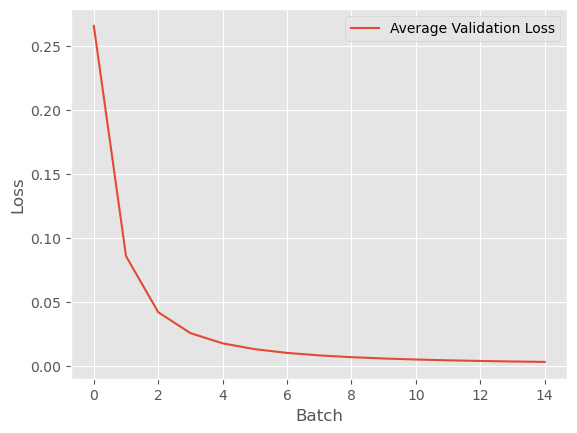

In [14]:
plot_history(validation_losses)